In [2]:
import networkx as nx
import numpy as np
import matplotlib as plt
import os
import collections

In [3]:
cwd = os.getcwd()
data_folder = cwd + "/../pydgraph/app/resources/"
graph_file_name = data_folder + "pydgraph.gml"
graph_out_file_name = data_folder + "pydgraph_updated.gexf"

In [4]:
G = nx.read_gml(graph_file_name)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 105
Number of edges: 227
Average in degree:   2.1619
Average out degree:   2.1619


## Indirect Dependency
When a module M1 imports another module M2, M1 automatically imports all the parents of M2. If we include such relationship directly in M1, we might get a completely different picture of the graph. 

Create such graph and analyze its degree distribution. Does it follow power law? 

In [7]:
def add_predecessors(graph, orgnode, currnode, dict_predecessors):
    for pnode in graph.predecessors(currnode):
        if pnode != node and pnode not in dict_predecessors[orgnode]:
            dict_predecessors[orgnode].append(pnode)
            add_predecessors(graph, orgnode, currnode, dict_predecessors)
            

GNew = G.copy()
dict_predecessors = dict()
for node in GNew.nodes():
    dict_predecessors[node] = list()
    for pnode in GNew.predecessors(node):
        if pnode != node and pnode not in dict_predecessors[node]:
            #dict_predecessors[node].append(pnode)
            add_predecessors(GNew, node, pnode, dict_predecessors)

for node in dict_predecessors:
    for child in dict_predecessors[node]:
        GNew.add_edge(node, child)


In [10]:
print(nx.info(GNew))

Name: 
Type: DiGraph
Number of nodes: 105
Number of edges: 486
Average in degree:   4.6286
Average out degree:   4.6286


## Analyze degree distribution
1. Make a comment whether this is random graph or scale free graph
2. Make a comment on degree distribution
3. Differentiate in_degree and out_degree

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def degree_distribution(graph):
    plt.subplot(3, 2, 1)
    cc = list(graph.degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)

    plt.subplot(3, 2, 2)
    cc = list(graph.in_degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)

    plt.subplot(3, 2, 3)
    cc = list(graph.out_degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)
    
import math
#This function draws degree distribution histogram and then line chart for same degree distribution but in log scale
def draw_degree_distribution(graph):
    data = list(dict(nx.degree(graph)).values())
    
    plt.figure(1)
    plt.subplot(1, 2, 1)
    h = plt.hist(data, bins=10)
    plt.title('Degree Distribution Histogram')

    #Now draw log scale 
    plt.subplot(1, 2, 2)
    y,binEdges=np.histogram(data,bins=10)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

    bincenters_nonzero = []
    ylog = []
    for i in range(len(y)):
        if(y[i] > 0):
            bincenters_nonzero.append(math.log(bincenters[i]))
            ylog.append(math.log(y[i]))

    plt.plot(bincenters_nonzero,ylog,'-')
    plt.title('Degree Distribution Histogram in Log Scale')
    plt.tight_layout(pad=0.8, w_pad=5.8, h_pad=1.0)

    plt.show()


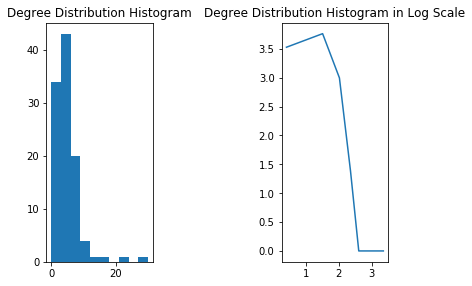

In [19]:
draw_degree_distribution(G)

<B>Observations:</B>
1. The degree distribution neither bionomial nor follows power law. Looks like the graph is random graph.
2. The total degree is mostly in the range of 1 to 9. Average degree is 4.32
3. The average in_degree and out_degree is same - around 2.16

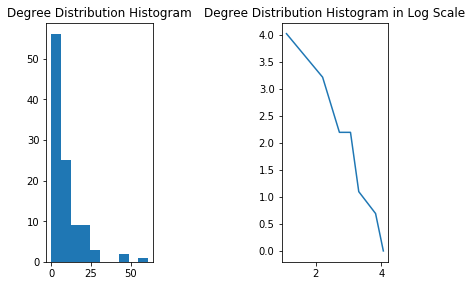

In [20]:
draw_degree_distribution(GNew)

## Friendship Paradox

Does this network observe friendship paradox? If yes, how we can utilize it?

In [6]:
def avgNeighborDegree(node, graph):
    avg_degree = np.mean([graph.out_degree(node) for node in graph.neighbors(node)])
    return avg_degree

def computeFriendshipParadoxFraction(graph):
    friendship_paradox_holds = [1 if graph.out_degree(node) <  avgNeighborDegree(node, graph) else 0 for node in graph.nodes()]
    fraction_success = sum(friendship_paradox_holds)/len(friendship_paradox_holds)
    return fraction_success

fraction_success = computeFriendshipParadoxFraction(G)
print("The fraction of nodes for which friendship paradox holds true is ", fraction_success)

The fraction of nodes for which friendship paradox holds true is  0.09523809523809523


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<B>Observation:</B> The friendship paradox does not hold true for this network.

In [14]:
fraction_success_new = computeFriendshipParadoxFraction(GNew)
print("The fraction of nodes for which friendship paradox holds true is ", fraction_success_new)

The fraction of nodes for which friendship paradox holds true is  0.5904761904761905


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<B>Observation:</B> The friendship paradox holds true for this variation of network.

## Explore Centralities and Communities

In [35]:
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, "betweenness", betweenness)
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, "closeness", closeness_centrality)
nx.write_gexf(G, graph_out_file_name)

## Explore Robustness
If there are bugs found in some central module, how it will be propogated? Can this be considered as SI or SIS propogation mechanism? How well this network can handle random failure and targetted failures?